In [1]:
# install tflite model maker
!pip install tflite-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# install libportaudio2
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (124 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [18]:
# import libraries needed
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader

from tflite_model_maker import model_spec
from tflite_model_maker.config import QuantizationConfig

from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# extract zip file dataset
!unzip "/content/drive/MyDrive/DATASET TANAMAN HERBAL.zip"

Archive:  /content/drive/MyDrive/DATASET TANAMAN HERBAL.zip
   creating: DATASET TANAMAN HERBAL/Daun Jambu Biji/
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (1).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (10).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (100).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (11).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (12).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (13).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (14).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (15).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (16).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (17).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (18).JPG  
  inflating: DATASET TANAMAN HERBAL/Daun Jambu Biji/jambu biji (19).JPG  

In [7]:
# checking amount of data in each label
print("Daun Jambu Biji: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Jambu Biji")))
print("Daun Kari: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Kari")))
print("Daun Kemangi: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Kemangi")))
print("Daun Kunyit: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Kunyit")))
print("Daun Mint: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Mint")))
print("Daun Pepaya: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Pepaya")))
print("Daun Sirih: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Sirih")))
print("Daun Sirsak: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Daun Sirsak")))
print("Lidah Buaya: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Lidah Buaya")))
print("Teh Hijau: ", len(os.listdir("/content/DATASET TANAMAN HERBAL/Teh Hijau")))

Daun Jambu Biji:  100
Daun Kari:  100
Daun Kemangi:  100
Daun Kunyit:  100
Daun Mint:  100
Daun Pepaya:  100
Daun Sirih:  100
Daun Sirsak:  100
Lidah Buaya:  100
Teh Hijau:  100


In [9]:
# load the dataset and split it into train, validation and test dataset with 8:1:1 ratio
data = DataLoader.from_folder('/content/DATASET TANAMAN HERBAL')
train_dataset, x = data.split(0.8)
validation_dataset, test_dataset = x.split(0.5)

INFO:tensorflow:Load image with size: 1000, num_label: 10, labels: Daun Jambu Biji, Daun Kari, Daun Kemangi, Daun Kunyit, Daun Mint, Daun Pepaya, Daun Sirih, Daun Sirsak, Lidah Buaya, Teh Hijau.


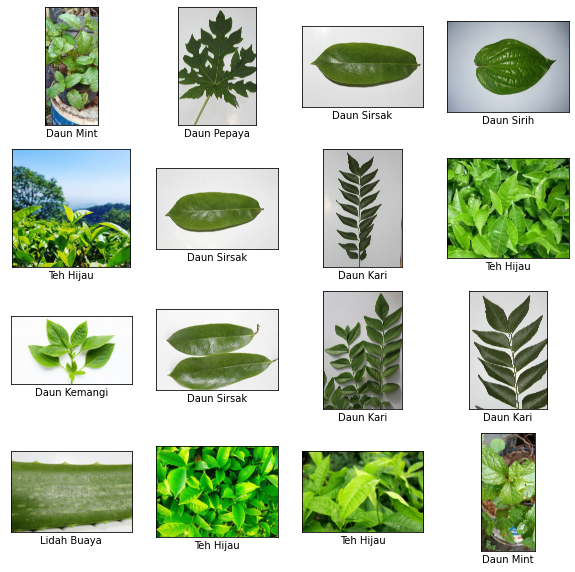

In [10]:
# display some image examples from dataset
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(16)):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [14]:
# adding augmentation to increase model accuracy
augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                              input_shape=(224, 224, 3)),
                                 layers.experimental.preprocessing.RandomRotation(0.1),
                                 layers.experimental.preprocessing.RandomZoom(0.1),
                                 layers.experimental.preprocessing.Rescaling(1/255.)
                                 ])                

In [15]:
# define the transfer learning model with MobileNetV2 CNN architecture
model = image_classifier.create(train_dataset,
                                model_spec='mobilenet_v2',
                                validation_data=validation_dataset,
                                batch_size=32,
                                epochs=30,
                                dropout_rate=0.2,
                                learning_rate=0.0001,
                                momentum=0.9,
                                shuffle=1000,
                                use_augmentation=augmentation)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             2257984   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
None
INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
25/25 [==============================] - 110s 4s/step - loss: 2.5533 - accuracy: 0.1400 - val_loss: 2.3345 - val_accuracy: 0.1800
Epoch 2/30
25/25 [==============================] - 107s 4s/step - loss: 2.3138 - accuracy: 0.2000 - val_loss: 2.0550 - val_accuracy: 0.2200
Epoch 3/30
25/25 [==============================] - 105s 4s/step - loss: 2.0597 - accuracy: 0.2700 - val_loss: 1.8410 - val_accuracy: 0.3500
Epoch 4/30
25/25 [==============================] - 105s 4s/step - loss: 1.8971 - accuracy: 0.3550 - val_loss: 1.6655 - val_accuracy: 0.5100
Epoch 5/30
25/25 [==============================] - 106s 4s/step - loss: 1.7763 - accuracy: 0.4288 - val_loss: 1.5141 - val_accuracy: 0.6000
Epoch 6/30
25/25 [==============================] - 105s 4s/step - loss: 1.6705 - accuracy: 0.5138 - val_loss: 1.3882 - val_accuracy: 0.7300
Epoch 7/30
25/25 [==============================] - 105s 4s/step - loss: 1.5649 - accuracy: 0.5600 - val_loss: 1.2827 - val_accuracy: 0.8100
Epoch 8/30
25

In [16]:
# evaluate the test_dataset
loss, accuracy = model.evaluate(test_dataset)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


4/4 [==============================] - 66s 2s/step - loss: 0.7397 - accuracy: 0.9300


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


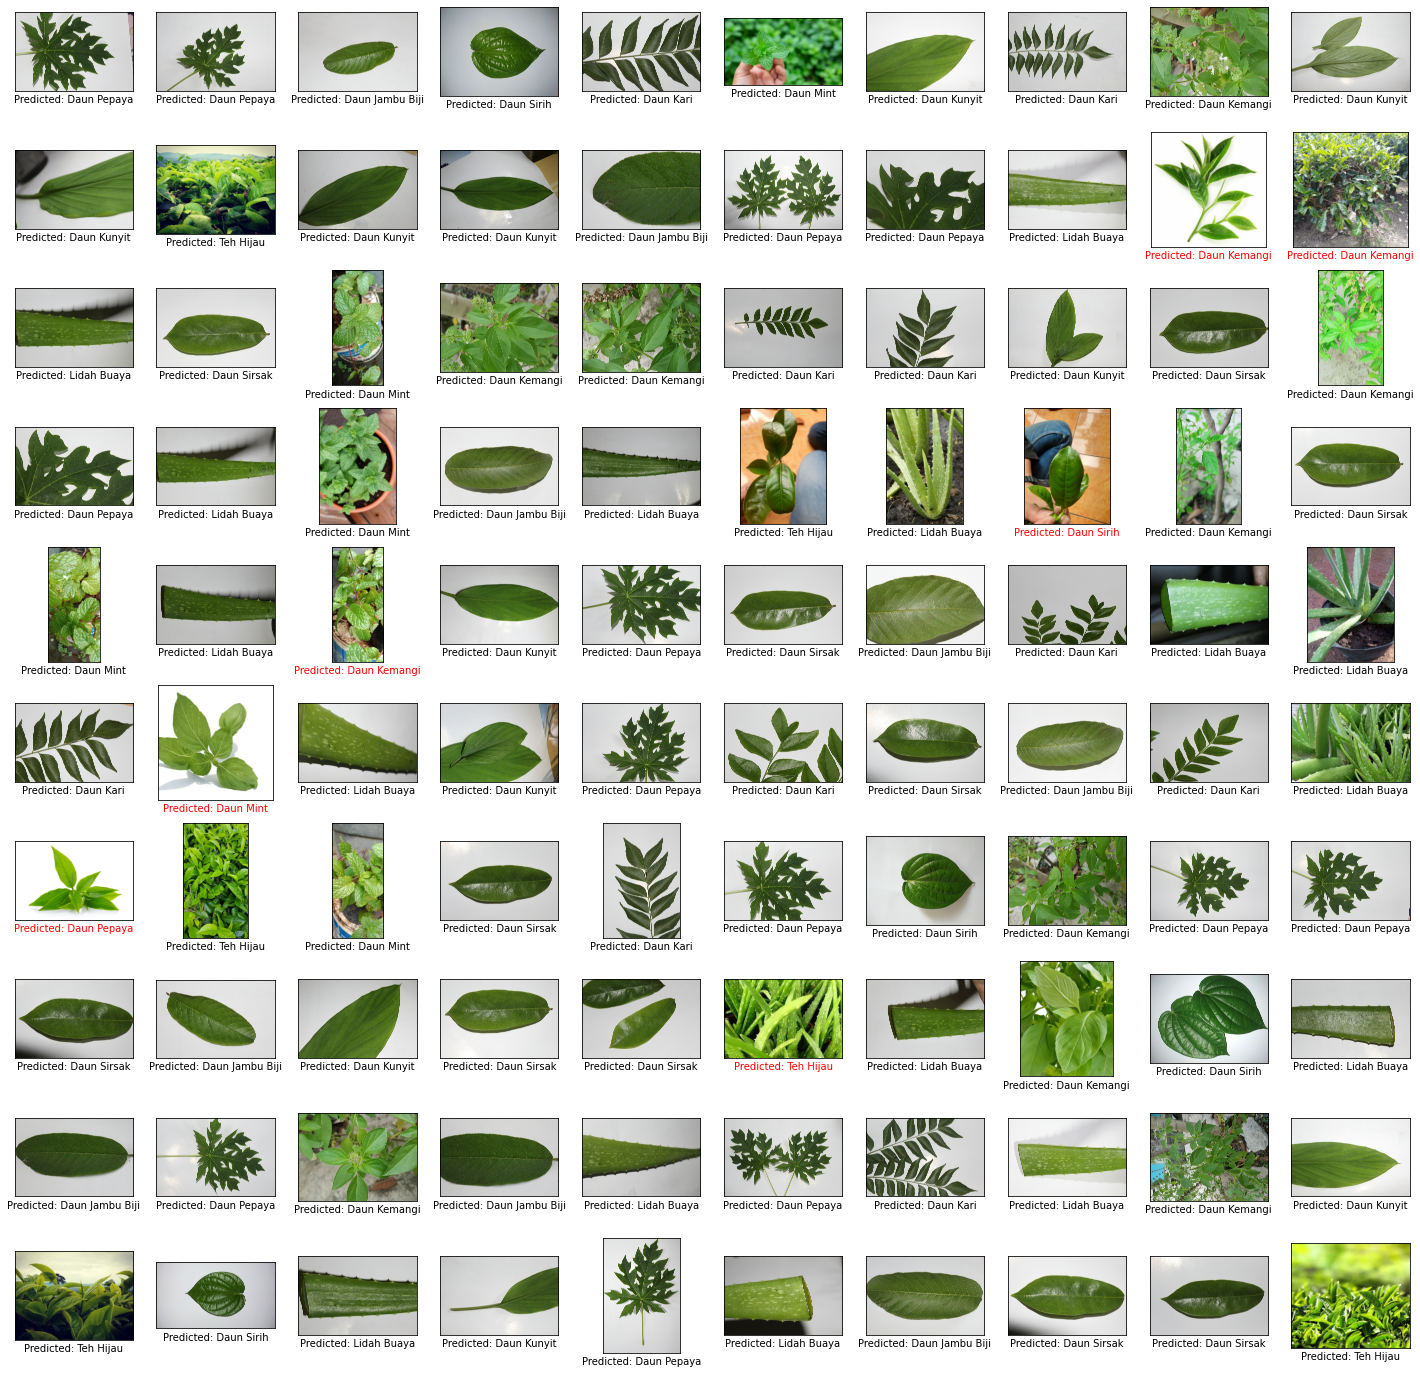

In [22]:
# define function to return black=True and red=False in prediction result
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# display 100 test images and their predicted labels
plt.figure(figsize=(25, 25))
predicts = model.predict_top_k(test_dataset)
for i, (image, label) in enumerate(test_dataset.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_dataset.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [23]:
# post training quantization to reduce model size and inference latency
config = QuantizationConfig.for_float16()

In [25]:
# export the TensorFlow Lite model
model.export(export_dir='paranmo', tflite_filename='Paranmo_final.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmp8hij2p5o/assets


INFO:tensorflow:Assets written to: /tmp/tmp8hij2p5o/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp6zqvorhx/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp6zqvorhx/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: paranmo/Paranmo_final.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: paranmo/Paranmo_final.tflite


In [27]:
# evaluate the tflite model with the evaluate_tflite method
model.evaluate_tflite('paranmo/Paranmo_final.tflite', test_dataset)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


{'accuracy': 0.93}

In [34]:
# download the tflite file
try:
    from google.colab import files
    files.download('paranmo/Paranmo_final.tflite')
except:
    pass